In [1]:
import easygraph as eg
import csv
import pandas as pd
import networkx as nx
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import  pyplot
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, roc_curve, recall_score, f1_score, roc_auc_score, accuracy_score

def make_graph(filepath:str):
    G=eg.Graph()
    nodes=[]
    nodes_attr=[]
    edges=[]
    edges_attr=[]
    f=open(filepath,'r')
    next(f)
    csv_reader=csv.reader(f)
    for row in csv_reader:
        i=str(row[0])
        i_affifiation=str(row[1])
        i_country=str(row[2])
        j=str(row[3])
        j_affifiation=str(row[4])
        j_country=str(row[5])
        year=int(row[6])
        area=str(row[7])

        nodes.append(i)
        temp1={}
        temp1['affiliation']=i_affifiation
        temp1['country']=i_country
        nodes_attr.append(temp1)

        nodes.append(j)
        temp2={}
        temp2['affiliation']=j_affifiation
        temp2['country']=j_country
        nodes_attr.append(temp2)

        edges.append((i,j))
        temp3={}
        temp3['year']=year
        temp3['area']=area
        edges_attr.append(temp3)

    G.add_nodes(nodes,nodes_attr)
    G.add_edges(edges,edges_attr)
    return G


In [2]:
# author
G1=make_graph('faculty-coauthors.csv')

In [3]:
SHS=sorted(eg.constraint(G1).items(), key=lambda d: d[1])

In [4]:
import random
con=eg.constraint(G1)
con=sorted(con.items(), key=lambda d: d[1])


SHS1=[]
nonSHS1=[]

kk=int(len(G1)*0.05)
k=0
for i in con:
    if k<kk:
        SHS1.append(i[0])
        k+=1
    else:
        break
        
random.seed(0)
while len(nonSHS1)<kk:
    t=random.sample(con, 1)
    if t[0][0] not in SHS1 and t[0][0] not in nonSHS1:
        nonSHS1.append(t[0][0])
        

In [6]:
# A. Suruliandi	Manonmaniam Sundaranar University	tcss	2	0.58333	2021
f1=open("generated-author-info.csv",'r')
f2=open("country-info2.csv","r")
next(f1)
next(f2)
csv_reader1=csv.reader(f1)
csv_reader2=csv.reader(f2)
List={}
country_list={}
for row in csv_reader2:
    country_list[row[0]]=row[2]
for row in csv_reader1:
    if row[0] in SHS1 or row[0] in nonSHS1:
        if row[0] not in List:
            List[row[0]]={}
            List[row[0]]['country']=country_list[row[1]]
            List[row[0]]['university']=row[1]
            List[row[0]]['journal']=[]
            List[row[0]]['journal'].append(row[2])
            List[row[0]]['paper']=float(row[3])
            List[row[0]]['count']=[]
            List[row[0]]['count'].append(float(row[4]))
            List[row[0]]['year']=[]
            List[row[0]]['year'].append(int(row[5]))
            if row[0] in SHS1:
                List[row[0]]['label']=1
            else:
                List[row[0]]['label']=0
        else:
            if row[2] not in List[row[0]]['journal']:
                List[row[0]]['journal'].append(row[2])
            List[row[0]]['paper']+=float(row[3])
            List[row[0]]['count'].append(float(row[4]))
            List[row[0]]['year'].append(int(row[5]))


In [7]:
data={
    'country':[],
    'university':[],
    'journal':[],
    'paper':[],
    'count':[],
    'year':[],
    'label':[]
}
for i in List:
    data['country'].append(List[i]['country'])
    data['university'].append(List[i]['university'])
    data['journal'].append(len(List[i]['journal']))
    data['paper'].append(List[i]['paper'])
    data['count'].append(np.mean(List[i]['count']))
    data['year'].append(len(List[i]['year'])*2021-sum(List[i]['year']))
    data['label'].append(List[i]['label'])

In [8]:
label_encoder = LabelEncoder()
data['country'] = label_encoder.fit_transform(data['country'])
data['university'] = label_encoder.fit_transform(data['university'])
data=pd.DataFrame(data)
data = pd.get_dummies(data)
data_x = data.drop('label',axis = 1)
data_y = data['label']
Xtrain, Xtest, Ytrain, Ytest = train_test_split(data_x,data_y,test_size=0.3,random_state=0)

Best parameters set found on development set:

{'booster': 'gbtree', 'colsample_bytree': 0.8, 'eval_metric': 'auc', 'gamma': 2, 'learning_rate': 0.3, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 50, 'num_class': 2, 'objective': 'multi:softprob', 'subsample': 0.8, 'use_label_encoder': 'False'}

Grid scores on development set:

0.891 (+/-0.149) for {'booster': 'gbtree', 'colsample_bytree': 0.8, 'eval_metric': 'auc', 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 10, 'num_class': 2, 'objective': 'multi:softprob', 'subsample': 0.8, 'use_label_encoder': 'False'}
0.897 (+/-0.103) for {'booster': 'gbtree', 'colsample_bytree': 0.8, 'eval_metric': 'auc', 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 50, 'num_class': 2, 'objective': 'multi:softprob', 'subsample': 0.8, 'use_label_encoder': 'False'}
0.905 (+/-0.097) for {'booster': 'gbtree', 'colsample_bytree': 0.8, 'eval_metric': 'auc', 'gamma': 0, 'l

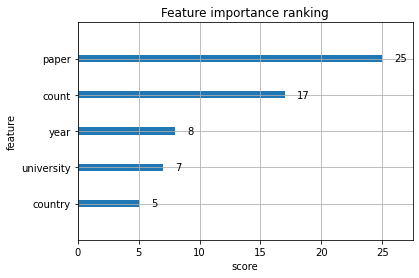

In [11]:
warnings.filterwarnings("ignore")
parameters_grid_XGB = {
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [10, 50, 100], 
    'max_depth': [4,6,8], 
    'min_child_weight':[1],
    'subsample': [0.8],
    'colsample_bytree':[0.8], 
    'gamma':[0,2,4],
    
    'booster': ['gbtree'],
    'num_class':[2],
    'eval_metric':["auc"],
    'objective':['multi:softprob'],
    #'seed':[0],
    'use_label_encoder':['False']
}
XGB = XGBClassifier()
grid = GridSearchCV(XGB, parameters_grid_XGB, cv=5, scoring='precision')
grid.fit(Xtrain, Ytrain)

print("Best parameters set found on development set:")
print()
print(grid.best_params_)
print()
print("Grid scores on development set:")
print()
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()
print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
bclf = grid.best_estimator_
bclf.fit(Xtrain, Ytrain)
y_true = Ytest
y_pred = bclf.predict(Xtest)
y_pred_pro = bclf.predict_proba(Xtest)
y_scores = pd.DataFrame(y_pred_pro, columns=bclf.classes_.tolist())[1].values
print(classification_report(y_true, y_pred))
auc_value = roc_auc_score(y_true, y_scores)
print("auc_value:")
print(auc_value)

plot_importance(bclf,title='Feature importance ranking', xlabel='score', ylabel='feature')
pyplot.show()
